### 1. Package imports

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

%matplotlib inline

from utility import * # custom functions that are used throughout this script

### 2. Read data

In [12]:
path_input_file = os.path.join(os.getcwd(), "01_data", "data_prepared.csv")

data = pd.read_csv(path_input_file)
data = data.set_index("PassengerId", drop=True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,TrainTest,FamilyAllSurvived,FamilyAllDied,Fsize,...,"AgeBin_(64.0, 72.0]","AgeBin_(72.0, 80.0]",Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None,Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22,1,0,1.98,Train,0,1,2,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1,38,1,0,4.27,Train,0,0,2,...,0,0,0,1,0,0,0,0,0,0
3,1.0,3,26,0,0,2.07,Train,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1.0,1,35,1,0,3.97,Train,0,0,2,...,0,0,0,1,0,0,0,0,0,0
5,0.0,3,35,0,0,2.09,Train,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 42 columns):
Survived                   891 non-null float64
Pclass                     1309 non-null int64
Age                        1309 non-null int64
SibSp                      1309 non-null int64
Parch                      1309 non-null int64
Fare                       1309 non-null float64
TrainTest                  1309 non-null object
FamilyAllSurvived          1309 non-null int64
FamilyAllDied              1309 non-null int64
Fsize                      1309 non-null int64
SharedTicket               1309 non-null int64
SharedTicketAllSurvived    1309 non-null int64
SharedTicketAllDied        1309 non-null int64
FareBin                    1309 non-null int64
NumberCabins               1309 non-null int64
SharedCabin                1309 non-null int64
SharedCabinAllSurvived     1309 non-null int64
SharedCabinAllDied         1309 non-null int64
Sex_male                   1309 non-null in

### 3. Data prep

#### Rename AgeBins (to avoid issues with XGBoost)

In [28]:
bins = [col for col in data.columns if col.startswith("AgeBin")]
bins = dict((b, f"AgeBin_{i}") for i, b in enumerate(bins))

In [34]:
data.rename(bins, axis=1, inplace=True)

#### Split data

In [37]:
train, test = split_data(data)

#### StandardScaler

In [38]:
columns_to_scale = ["Age", "Fare", "Pclass", "SibSp", "Parch","Fsize"]
train[columns_to_scale] = train[columns_to_scale].astype(float)
scaler = StandardScaler().fit(train[columns_to_scale])

In [39]:
train[columns_to_scale] = scaler.transform(train[columns_to_scale])
test[columns_to_scale] = test[columns_to_scale].astype(float)
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

### 4. Model selection
All algorithms will be used to predict the actual test data. The results will be uploaded to Kaggle, and the results will be tracked.
For now, the default parameters are used. Some of them are stated explicitly to surpress warnings about future changes of the default value.

In [46]:
algorithms = [RandomForestClassifier(n_estimators=100),
              GradientBoostingClassifier(n_estimators=100),
              ExtraTreesClassifier(n_estimators=100),
              AdaBoostClassifier(),
              DecisionTreeClassifier(),
              BaggingClassifier(),
              SVC(probability=True, gamma="auto"),
              XGBClassifier(),
              KNeighborsClassifier(),
              LogisticRegression(solver="lbfgs", max_iter=1000),
              LogisticRegressionCV(solver="lbfgs", cv=3, max_iter=1000)]

In [49]:
path_output_folder = os.path.join(os.getcwd(), "02_predictions")
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]

for algo in algorithms:
    name = algo.__class__.__name__
    algo.fit(X_train, y_train)
    predictions = pd.DataFrame()
    predictions["PassengerId"] = test.index
    predictions["Survived"] = algo.predict(test)
    predictions["Survived"] = predictions["Survived"].astype(int)
    predictions.to_csv(os.path.join(path_output_folder, f"predictions_{name}.csv"), index=False)

In [68]:
results = [("AdaBoostClassifier", 0.75119), 
           ("BaggingClassifier", 0.73684),
           ("DecisionTreeClassifier", 0.71770),
           ("ExtraTreesClassifier", 0.72727), 
           ("GradientBoostingClassifier", 0.76555),
           ("KNeighborsClassifier", 0.78947),
           ("LogisticRegression", 0.77511), 
           ("LogisticRegressionCV", 0.76555),
           ("RandomForestClassifier", 0.74162),
           ("SVC", 0.79904),
           ("XGBClassifier", 0.77990)]

In [69]:
results = pd.DataFrame(results, columns=["Classifier", "Score"])
results = results.sort_values("Score", ascending=True)

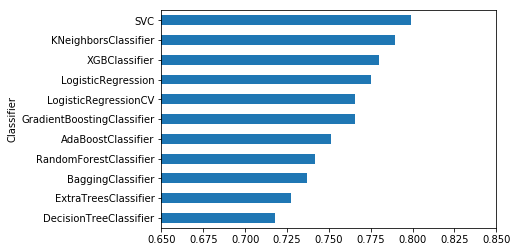

In [70]:
ax = results.plot(kind="barh", x="Classifier")
ax.get_legend().remove()
ax.set_xlim(0.65, 0.85);